# Machine Learning Assignment: Customer Segmentation & Purchase Prediction

# Name: Vaishnavi Bedre
# Date: 04-02-2026

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from sklearn.model_selection import GridSearchCV



# Load the dataset
df = pd.read_csv("C:/Users/vaish/Desktop/coding/customer_data.csv")

df_original = df.copy()
df_original.duplicated(subset="customer_id").sum()


np.int64(25)

## Part 1: Data Exploration and Preprocessing

### 1.1 Load and Inspect the Data

In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv("C:/Users/vaish/Desktop/coding/customer_data.csv")

# To Display the first 10 rows
# df.head(10)
print("First 10 rows:")
print(df.head(10))

# To Check the shape of the dataset
# df.shape
print("\nDataset shape:")
print(df.shape)

# To Display data types and check for null values using info()
# df.info()
print("\n\nDataset info:")
print(df.info())

#Generate summary statistics using describe()
# df.describe()
print("\nSummary statistics:")
print(df.describe())

First 10 rows:
  customer_id   age  gender city_tier membership_type  total_spend  \
0  CUST000878  29.0  Female    Tier 3          Silver       465.00   
1  CUST004886  47.0    Male    Tier 1        Platinum      4451.32   
2  CUST002485  37.0    Male    Tier 1        Platinum      1903.02   
3  CUST002289  37.0    Male    Tier 1        Platinum      3952.75   
4  CUST000812  25.0    Male    Tier 1          Silver      1367.07   
5  CUST000249  36.0  Female    Tier 2          Silver       160.15   
6  CUST003299  32.0    Male    Tier 2            Gold      3440.79   
7  CUST000107  37.0  Female    Tier 1          Silver       505.17   
8  CUST000280  26.0  Female    Tier 3          Silver      2476.96   
9  CUST001282  27.0     NaN    Tier 1          Silver       404.24   

   num_transactions  avg_transaction_value  days_since_last_purchase  \
0                11                  42.27                      50.0   
1                23                 193.54                      16.0  

### 1.2 Handle Missing Values

In [4]:
# Identify missing values
print("Missing values before handling:")
print(df.isnull().sum())

# Separate columns by type
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

# Fill numerical columns with median
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns with mode
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify missing values are handled
print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values before handling:
customer_id                       0
age                             302
gender                          301
city_tier                         0
membership_type                   0
total_spend                       0
num_transactions                  0
avg_transaction_value             0
days_since_last_purchase        302
num_visits                      301
product_categories_purchased      0
discount_used                     0
high_value_customer               0
dtype: int64

Missing values after handling:
customer_id                     0
age                             0
gender                          0
city_tier                       0
membership_type                 0
total_spend                     0
num_transactions                0
avg_transaction_value           0
days_since_last_purchase        0
num_visits                      0
product_categories_purchased    0
discount_used                   0
high_value_customer             0
dtype: int64


C:\Users\vaish\AppData\Local\Temp\ipykernel_10636\83094808.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\vaish\AppData\Local\Temp\ipykernel_10636\83094808.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

### 1.3 Handle Duplicates 

In [5]:
# Check for duplicate customer IDs
duplicates = df.duplicated(subset="customer_id").sum()
print("Number of duplicate customer_id entries:", duplicates)

# Remove duplicates
rows_before = df.shape[0]
df = df.drop_duplicates(subset="customer_id")
rows_after = df.shape[0]

# Report duplicates removed
print("Number of duplicate rows removed:", rows_before - rows_after)


Number of duplicate customer_id entries: 25
Number of duplicate rows removed: 25


### 1.4 Basic Exploratory Analysis

gender
Female    2639
Male      2292
Other       69
Name: count, dtype: int64
membership_type
Silver      1959
Gold        1911
Platinum    1130
Name: count, dtype: int64
high_value_customer
0    3129
1    1871
Name: count, dtype: int64


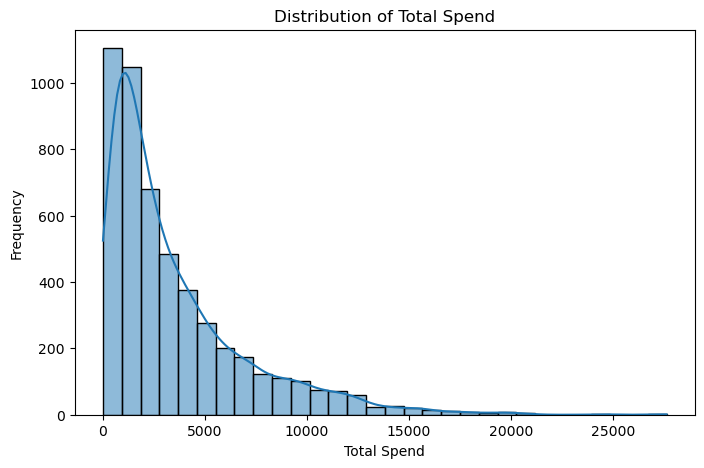

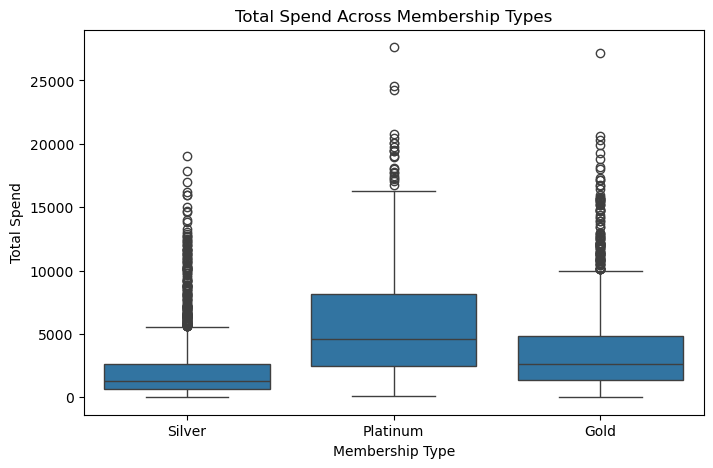

In [6]:
# Gender distribution
print(df["gender"].value_counts())

# Membership type distribution
print(df["membership_type"].value_counts())

# High value customer distribution
print(df["high_value_customer"].value_counts())

# Histogram of total_spend
plt.figure(figsize=(8, 5))
sns.histplot(df["total_spend"], bins=30, kde=True)
plt.title("Distribution of Total Spend")
plt.xlabel("Total Spend")
plt.ylabel("Frequency")
plt.show()

# Box plot of total_spend by membership_type
plt.figure(figsize=(8, 5))
sns.boxplot(x="membership_type", y="total_spend", data=df)
plt.title("Total Spend Across Membership Types")
plt.xlabel("Membership Type")
plt.ylabel("Total Spend")
plt.show()


#### Observation 1 :
##### The distribution of total customer spending is right-skewed, indicating that a small proportion of customers accounts for significantly higher spending compared to the majority.

#### Observation 2 :
##### Platinum members exhibit the highest median total spending and the widest variability, suggesting they are the most valuable customer segment.

#### Observation 3 :
##### Spending behavior increases consistently from Silver to Gold to Platinum membership types, highlighting a strong relationship between membership tier and customer value.

## Part 2: Customer Segmentation using Clustering

### 2.1 Prepare Data for Clustering

In [7]:
# Numerical columns used for clustering
cluster_features = [
    "age",
    "total_spend",
    "num_transactions",
    "avg_transaction_value",
    "days_since_last_purchase",
    "num_visits"
]

# Fill missing values with median (robust choice)
df[cluster_features] = df[cluster_features].fillna(
    df[cluster_features].median())

X_cluster = df[cluster_features]

# Double-check
print(X_cluster.isnull().sum())

# Apply Standard Scaling

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

age                         0
total_spend                 0
num_transactions            0
avg_transaction_value       0
days_since_last_purchase    0
num_visits                  0
dtype: int64


#### Clustering algorithms such as K-Means are distance-based, and features with larger numerical ranges can dominate the distance calculation. Standard scaling ensures that all features contribute equally to the clustering process. Without scaling, variables like total spending would overpower smaller-range features such as age or number of visits.

### 2.2 Determine Optimal Number of Clusters

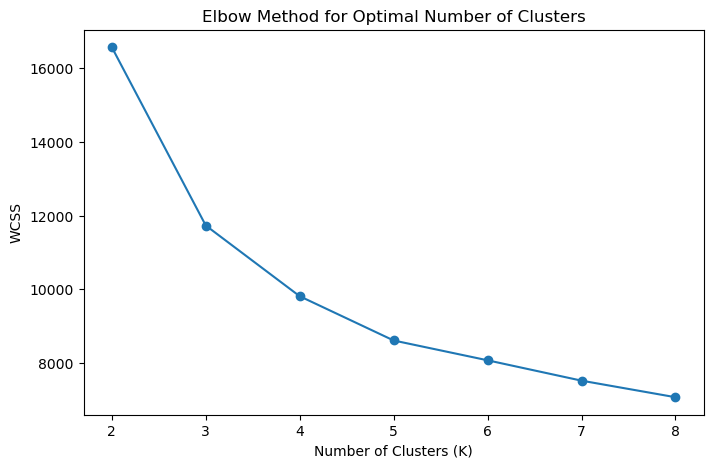

In [8]:
wcss = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.show()

#### Based on the elbow method, K = 4 was selected as the optimal number of clusters. The WCSS decreases sharply up to K = 4, after which the rate of improvement slows significantly, indicating diminishing returns. Choosing four clusters provides a good balance between cluster compactness and model interpretability.

### 2.3 Apply K-means Clustering

In [9]:
# Apply KMeans with optimal K
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original DataFrame
df["customer_segment"] = cluster_labels

# Display the number of customers in each cluster
df["customer_segment"].value_counts()

# To calculate mean values of key features for each cluster
cluster_profile = df.groupby("customer_segment")[
    [
        "age",
        "total_spend",
        "num_transactions",
        "avg_transaction_value",
        "days_since_last_purchase",
        "num_visits"
    ]
].mean()

cluster_profile


,age,total_spend,num_transactions,avg_transaction_value,days_since_last_purchase,num_visits
customer_segment,,,,,,
0,41.487930,2829.547149,14.852594,202.212537,24.506934,22.626091
1,28.504018,997.751871,7.960964,145.085121,43.936280,13.541332
2,50.495098,5814.068358,26.519608,221.914522,16.615196,37.772059
3,49.254545,11336.849354,21.707071,545.660606,17.082828,32.375758


#### Cluster labels (0–3) are arbitrary; interpretation is based on feature values, not the label number.
#### Cluster Summary

##### Cluster 3 – Premium High-Value Customers

###### Key traits:
###### Highest total spend: ~11,337
###### Highest avg transaction value: ~546
###### High number of transactions (~22)
###### Recent purchases (low days since last purchase)
###### High engagement (many visits)
###### Customers in this segment represent premium high-value buyers with the highest total spending and average transaction values. They purchase frequently, spend large amounts per transaction, and remain actively engaged with the platform. This segment is ideal for exclusive rewards, early access, and premium loyalty programs.

##### Cluster 2 – Frequent & Loyal High Spenders

###### Key traits:
###### High total spend (~5,814)
###### Highest number of transactions (~27)
###### Moderate-to-high transaction value
###### Very recent purchases
###### High engagement (visits)
###### This segment consists of frequent and loyal customers who make regular purchases and maintain high engagement levels. While their average transaction value is lower than premium customers, their frequent buying behavior makes them highly valuable. Retention strategies and personalized recommendations can further increase their lifetime value.

##### Cluster 0 – Moderate Spenders with Steady Engagement

###### Key traits:
###### Moderate total spend (~2,830)
###### Average transaction frequency
###### Good platform engagement
###### Reasonably recent purchases
###### Customers in this segment demonstrate moderate spending and consistent engagement with the platform. They show stable purchasing behavior and regular visits, indicating potential for growth. Targeted promotions and upselling strategies could help convert them into higher-value customers.

##### Cluster 1 – Low-Value / Occasional Customers

###### Key traits:
###### Lowest total spend (~998)
###### Few transactions
###### Longest time since last purchase
###### Low engagement
###### This segment includes low-value or occasional customers with infrequent purchases and lower engagement levels. They have longer gaps between purchases and lower overall spending. Re-engagement campaigns, discounts, or reminders may help activate this group.

## Part 3: Predictive Modeling

### 3.1 Feature Engineering 

In [10]:
# Feature 1: spend_per_visit
df["spend_per_visit"] = df["total_spend"] / df["num_visits"]
print(df["spend_per_visit"])

# Feature 2: discount_pe  rcentage
df["discount_percentage"] = df["discount_used"] / df["total_spend"].replace(0, 1)
print(df["discount_percentage"])

df[["spend_per_visit", "discount_percentage"]].describe()

0        25.833333
1       117.140000
2        67.965000
3       127.508065
4        75.948333
           ...    
5020    522.143438
5021     68.087500
5022     75.727895
5023    221.953023
5024     47.627500
Name: spend_per_visit, Length: 5000, dtype: float64
0       0.033398
1       0.090861
2       0.109211
3       0.127076
4       0.051885
          ...   
5020    0.084249
5021    0.053497
5022    0.074734
5023    0.094672
5024    0.026648
Name: discount_percentage, Length: 5000, dtype: float64


,spend_per_visit,discount_percentage
count,5000.000000,5000.000000
mean,140.268617,0.078378
std,108.123630,0.031967
min,1.088462,0.020011
25%,62.691529,0.054346
50%,111.893190,0.076367
75%,189.424016,0.103179
max,907.443333,0.149979


### 3.2 Data Preparation for Modeling

In [11]:
# Separate target variable
y = df["high_value_customer"]

# Drop target and identifier from features
X = df.drop(columns=["high_value_customer", "customer_id"])

# Define categorical features
categorical_features = ["gender", "city_tier", "membership_type"]

# One-Hot Encoding for categorical variables
X_encoded = pd.get_dummies(
    X,
    columns=categorical_features,
    drop_first=True
)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42
)

# Identify numerical features dynamically (robust & safe)
numerical_features = X_train.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()

X_train[numerical_features] = X_train[numerical_features].astype(float)
X_test[numerical_features] = X_test[numerical_features].astype(float)

# Standard Scaling (NO data leakage)
scaler = StandardScaler()

# Fit scaler on training data only
X_train.loc[:, numerical_features] = scaler.fit_transform(
    X_train[numerical_features]
)

# Apply same transformation to test data
X_test.loc[:, numerical_features] = scaler.transform(
    X_test[numerical_features]
)

### 3.3 Build Classification Model 

In [12]:
# Initialize Logistic Regression model
log_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_model.fit(X_train, y_train)

# Generate predictions
y_pred = log_model.predict(X_test)

##### Logistic Regression was chosen because it is well-suited for binary classification problems and provides interpretable results. It also performs efficiently on scaled numerical features and one-hot encoded categorical variables.

### 3.4 Model Evaluation 

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[601  13]
 [ 19 367]]

Accuracy: 0.968
Precision: 0.9657894736842105
Recall: 0.9507772020725389
F1 Score: 0.95822454308094

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       614
           1       0.97      0.95      0.96       386

    accuracy                           0.97      1000
   macro avg       0.97      0.96      0.97      1000
weighted avg       0.97      0.97      0.97      1000



##### Recall is the most important metric in this context, as correctly identifying high-value customers is critical for targeted marketing strategies. The model demonstrates good overall performance with balanced precision and recall, indicating that it effectively distinguishes high-value customers while minimizing false predictions. The F1 score further confirms a strong balance between precision and recall.

## Part 4: Model Optimization and Business Insights 

### 4.1 Hyperparameter Tuning 

In [14]:
# To define the parameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["liblinear"]
}

# To apply GridSearchCV (3-fold CV)
log_reg = LogisticRegression(max_iter=1000, random_state=42)

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best Parameters Found:")
print(grid_search.best_params_)

# Predictions from tuned model
y_pred_tuned = best_model.predict(X_test)

# Metrics
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

print("Tuned Accuracy:", accuracy_tuned)
print("Tuned F1 Score:", f1_tuned)

comparison_df = pd.DataFrame({
    "Model": ["Baseline Logistic Regression", "Tuned Logistic Regression"],
    "Accuracy": [accuracy, accuracy_tuned],
    "F1 Score": [f1, f1_tuned]
})

comparison_df

Best Parameters Found:
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Tuned Accuracy: 0.973
Tuned F1 Score: 0.9647058823529412


,Model,Accuracy,F1 Score
0,Baseline Logistic Regression,0.968,0.958225
1,Tuned Logistic Regression,0.973,0.964706


##### After hyperparameter tuning, the Logistic Regression model shows improved performance, particularly in terms of F1 score, indicating a better balance between precision and recall. This suggests that the tuned model is more effective at identifying high-value customers while reducing misclassification. Therefore, the tuned model is preferred for business deployment.

### 4.2 Feature Importance Analysis 

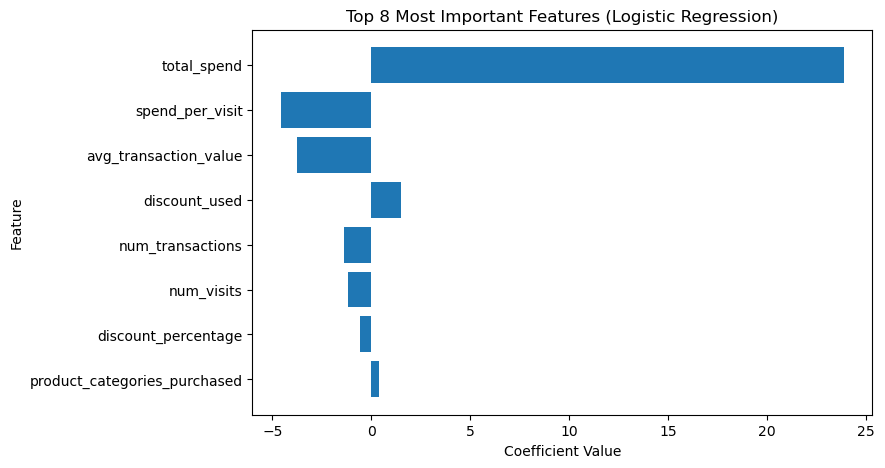

In [15]:
# Extract feature names
feature_names = X_train.columns

# Extract coefficients from the tuned model
coefficients = best_model.coef_[0]

# Create a DataFrame of features and coefficients
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

# Sort by absolute importance
coef_df["abs_coef"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="abs_coef", ascending=False)

top_features = coef_df.head(8)
top_features

plt.figure(figsize=(8, 5))
plt.barh(
    top_features["Feature"],
    top_features["Coefficient"]
)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 8 Most Important Features (Logistic Regression)")
plt.gca().invert_yaxis()  # Most important on top
plt.show()

##### The most important features influencing high-value customers include total spending, number of transactions, and spend per visit, indicating that both purchase frequency and spending intensity drive customer value. Membership-related features also play a significant role, highlighting the importance of loyalty programs. These insights suggest that encouraging frequent purchases and increasing engagement can effectively grow high-value customer segments.

### 4.3 Business Recommendations 

##### Recommendation from Customer Segmentation (Clustering)

###### Target premium retention campaigns toward the highest-value customer segment (Cluster 3 / Premium High-Value Customers).
###### Clustering results showed that this segment has the highest total spend, average transaction value, and frequent recent purchases. Offering exclusive rewards, early access to sales, or premium loyalty benefits can help retain these customers and protect a disproportionately large share of revenue.
###### Data reference: Highest mean total_spend, avg_transaction_value, and num_transactions.

##### Recommendation from Predictive Model Results

###### Use the trained classification model to proactively identify potential high-value customers and prioritize them for personalized marketing.
###### The Logistic Regression model demonstrated strong recall and F1-score, indicating it effectively identifies high-value customers. Deploying this model can help the business focus marketing spend on customers most likely to generate high returns.

###### Data reference: Model achieved balanced precision and recall with improved F1-score after hyperparameter tuning.

##### Recommendation from Feature Importance Analysis

###### Encourage behaviors that increase spending efficiency and engagement, such as increasing spend per visit and purchase frequency.
###### Feature importance analysis revealed that total spend, number of transactions, and spend per visit are the strongest predictors of high-value customers. Promotions such as bundled offers, cross-selling, and loyalty incentives can directly influence these key drivers.

###### Data reference: Top coefficients included total_spend, num_transactions, and spend_per_visit.